# ASAXS data reduction

some script description

## Libraries

In [1]:
import pandas as pd
import os
import csv
import time

import numpy as np
from scipy import optimize
import scipy.constants as con
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

import fabio
import pyFAI
from pyFAI.detectors import Pilatus1M

## Fuctions

In [2]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1.0, 0.7, 0.7))
         }
red_alpha = LinearSegmentedColormap('red_alpha', cdict)
plt.register_cmap(cmap=red_alpha)

## Read the basic data

In [15]:
# give the directory
data_dir = 'files\Data_for_ASAXS'
# name if data file ontaining all nessesary information
metaFileName = 'Data_for_ASAXS_ASCII_out_changed_test.txt'
pathTo_ReferenceFile = 'files\GC-Calibration_Final\GC-K_90um-new2015.dat'

# For the azimuthal integration result
bin_number = 400 #how many data points are generated in 1D curves
pixelsize = 172e-6 #m
scale = 10  # upscaling of poisson error for visibility

#read the meta file
path_to_metaFile = data_dir + os.sep + metaFileName
metaFrame = pd.read_csv(path_to_metaFile, sep='\t',index_col=0)

# Define divice identifiers
sampleName = 'SampleName'
monitorDiode = 'Keysight4'
monitorDeviation = 'Keysight4:StandardDeviation'
transmissionDiode = 'Keysight1'
transmissionDeviation = 'Keysight1:StandardDeviation'
acquisitionTime = 'PilatusAcqTime'
sampleThickness = 'SampleThickness'
sampleName = 'SampleName'
xray_energy = 'Energy'
maskFileName = 'MaskFile'
x_Center = 'x_Center' # in pixel
y_Center = 'y_Center' # in pixel
sampleToDetectorDistance = 'SampleToDet_Distance' # in meter

[]

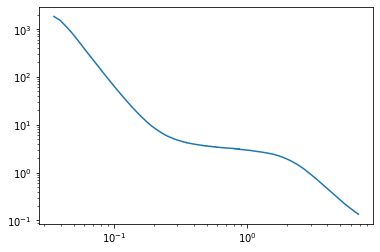

In [16]:
refData = np.genfromtxt(pathTo_ReferenceFile, delimiter=',',comments='#')
ref0_q = np.empty(0)
ref0_I = np.empty(0)
ref0_e = np.empty(0)
for i in range(refData.shape[0]):
    ref0_q = np.append(ref0_q,refData[i][0])
    ref0_I = np.append(ref0_I,refData[i][1])
    ref0_e = np.append(ref0_e,refData[i][2])
fig, ax = plt.subplots()
ax.plot(ref0_q, ref0_I)
ax.loglog()

## Data Handling

  File "<ipython-input-17-07b0e15bc74f>", line 120, in <module>
    detector=Pilatus1M(), wavelength=wavelength)


x_Center is 456.736 Reference is: pilatus_2020kw29tg14_00379.tif | Empty is: pilatus_2020kw29tg14_00378.tif
stay
stay
stay
stay
stay
stay
stay
stay
stay
stay
stay
stay
stay
stay
stay
stay
stay


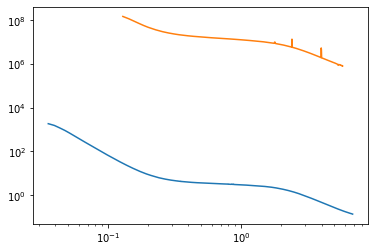

In [17]:
usedBackGr_index = 'False'
usedReference_index = 'False'
correctionFrame = pd.DataFrame()

for element in metaFrame.index:
    # read the image
    tiffName = metaFrame['Pilatus_filename'][element].split('/')[-1]
    tiffPath = data_dir + os.sep + tiffName
    image_object = fabio.open(tiffPath)
    image = image_object.data
    
    # read values
    name = metaFrame[sampleName][element]
    monitorI = metaFrame[monitorDiode][element]
    transmI = metaFrame[transmissionDiode][element]
    monitorI_dev = metaFrame[monitorDeviation][element]
    transmI_dev = metaFrame[transmissionDeviation][element]
    acqTime = metaFrame[acquisitionTime][element]
    thickness = metaFrame[sampleThickness][element]
    energy = metaFrame[xray_energy][element]
    
    empty_monitorI = metaFrame[monitorDiode][metaFrame['Empty_Index'][element]]
    empty_transmI = metaFrame[transmissionDiode][metaFrame['Empty_Index'][element]]
    
    # calculate transmission
    image_transmission = (transmI/monitorI)/(empty_transmI/empty_monitorI)
    image_transmission_deviation = image_transmission * (monitorI_dev/monitorI + transmI_dev/transmI)
    #print(tiffName,'measured',acqTime,'sec with transmission:' , image_transmission, '+/-',image_transmission_deviation)
    
    # normalizing image
    image = image / monitorI / acqTime / image_transmission
    
    # loead the image background file
    if int(metaFrame['Background_Index'][element]) == usedBackGr_index:
        #print('stay')
        pass
    else:
        # read the BackGround image
        tiffName_BackGr = metaFrame['Pilatus_filename'][metaFrame['Background_Index'][element]].split('/')[-1]
        tiffPath_BackGr = data_dir + os.sep + tiffName_BackGr
        image_object_BackGr = fabio.open(tiffPath_BackGr)
        image_BackGr = image_object_BackGr.data
        usedBackGr_index = int(metaFrame['Background_Index'][element])
        
        # read BackGround values
        monitorI_BG = metaFrame[monitorDiode][usedBackGr_index]
        transmI_BG = metaFrame[transmissionDiode][usedBackGr_index]
        monitorI_BG_dev = metaFrame[monitorDeviation][usedBackGr_index]
        transmI_BG_dev = metaFrame[transmissionDeviation][usedBackGr_index]
        acqTime_BG = metaFrame[acquisitionTime][usedBackGr_index]
        empty_monitorI_BG = metaFrame[monitorDiode][metaFrame['Empty_Index'][usedBackGr_index]]
        empty_transmI_BG = metaFrame[transmissionDiode][metaFrame['Empty_Index'][usedBackGr_index]]
        
        # calculate BackGround transmission
        image_transmission_BG = (transmI_BG/monitorI_BG)/(empty_transmI_BG/empty_monitorI_BG)
        image_transmission_BG_deviation = image_transmission_BG * (monitorI_BG_dev/monitorI_BG + transmI_BG_dev/transmI_BG)
        
        # normalizing BackGround image
        image_BackGr = image_BackGr / monitorI_BG / acqTime_BG / image_transmission_BG
        #print(usedBackGr_index,'=',image_transmission_BG,'+/-',image_transmission_BG_deviation)
    
    # Subtract the scattering Background
    image = image - image_BackGr
    image = image/thickness
    
    # loead the image Reference file
    if int(metaFrame['Reference_Index'][element]) == usedReference_index:
        print('stay')
        pass
    else:
        usedReference_index = int(metaFrame['Reference_Index'][element])
        # read the Reference image
        tiffName_Ref = metaFrame['Pilatus_filename'][metaFrame['Reference_Index'][usedReference_index]].split('/')[-1]
        tiffPath_Ref = data_dir + os.sep + tiffName_Ref
        image_object_Ref = fabio.open(tiffPath_Ref)
        image_Ref = image_object_Ref.data
        
        tiffName_Empty = metaFrame['Pilatus_filename'][metaFrame['Empty_Index'][usedReference_index]].split('/')[-1]
        tiffPath_Empty = data_dir + os.sep + tiffName_Ref
        image_object_Empty = fabio.open(tiffPath_Empty)
        image_Empty = image_object_Empty.data
        
        
        # read Reference values
        monitorI_Ref = metaFrame[monitorDiode][usedReference_index]
        transmI_Ref = metaFrame[transmissionDiode][usedReference_index]
        monitorI_Ref_dev = metaFrame[monitorDeviation][usedReference_index]
        transmI_Ref_dev = metaFrame[transmissionDeviation][usedReference_index]
        acqTime_Ref = metaFrame[acquisitionTime][usedReference_index]
        
        energy = metaFrame[xray_energy][usedReference_index]
        wavelength = con.h * con.c / con.e / energy  # m
        x_Center = metaFrame[x_Center][usedReference_index]
        y_Center = metaFrame[y_Center][usedReference_index]
        stDetDist = metaFrame[sampleToDetectorDistance][usedReference_index]
        maskFile = metaFrame[maskFileName][usedReference_index]
        
        
        empty_monitorI_Ref = metaFrame[monitorDiode][metaFrame['Empty_Index'][usedReference_index]]
        empty_transmI_Ref = metaFrame[transmissionDiode][metaFrame['Empty_Index'][usedReference_index]]
        empty_acqTime = metaFrame[acquisitionTime][metaFrame['Empty_Index'][usedReference_index]]
        
        # calculate Reference and Reference-BackGround transmission
        image_transmission_Ref = (transmI_Ref/monitorI_Ref)/(empty_transmI_Ref/empty_monitorI_Ref)
        image_transmission_Ref_deviation = image_transmission_Ref * (monitorI_Ref_dev/monitorI_Ref + transmI_Ref_dev/transmI)
        
        image_transmission_Empty = (empty_transmI_Ref/empty_monitorI_Ref)/(empty_transmI_Ref/empty_monitorI_Ref)
        
        
        # normalizing Reference image
        image_Ref = image_Ref / monitorI_Ref / acqTime_Ref / image_transmission_Ref
        image_Empty = image_Empty / empty_monitorI_Ref / empty_acqTime / image_transmission_Ref
        image_Ref = image_Ref - image_Empty
        
        print('x_Center is',x_Center,'Reference is:',tiffName_Ref,'| Empty is:', tiffName_Empty)
        
        #Do the azimutal integration of the Reference file
        # adress the mask
        ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,
                               detector=Pilatus1M(), wavelength=wavelength)
        # adress the mask
        ai_mask_path = data_dir + os.sep + maskFile
        ai_mask_object = fabio.open(ai_mask_path)
        ai_mask = ai_mask_object.data
        
        # usage of integrate 1d method
        ref_q, ref_I, ref_e = ai.integrate1d(image_Ref, bin_number, error_model='poisson', mask=ai_mask)
        
        # plot measured and known Reference data
        fig, ax = plt.subplots()
        ax.plot(ref0_q, ref0_I)
        ax.fill_between(ref_q, ref_I + scale * ref_e, ref_I - scale * ref_e, alpha=0.5)
        ax.plot(ref_q, ref_I)
        ax.loglog()




        
    correctionFrame = correctionFrame.append({'SampleName_Reduction':name,'Transm':image_transmission, 'TransmDev':image_transmission_deviation,'BackGrTransm':image_transmission_BG,'ReferenceTransm':image_transmission_Ref},ignore_index=True)       
    #fig, ax = plt.subplots()
    #ax.imshow(image, norm=LogNorm())
    
outputFrame = metaFrame.join(correctionFrame)

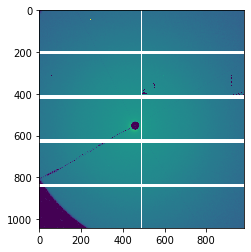

In [7]:
fig, ax = plt.subplots()
ax.imshow(image_Ref, norm=LogNorm())

In [108]:
#x_Center = metaFrame['x_Center'][0]# 456.736 #pix
#y_Center = 556.579 #pix
#directBeamDistance = 801.690 #mm
dist = stDetDist #m
# give the pixel size in meter
pixelsize = 172e-6 #m
energy = 7000 # in eV
#calculate wavelength, scattering angle and sample to detector distance
wavelength = con.h * con.c / con.e / energy  # m
print(energy,'eV correspond to',wavelength*(10**9),'nm','at a distance of',dist,'m')

7000 eV correspond to 0.1771202819948674 nm at a distance of 0.80169 m


In [113]:
# adress the mask
ai = pyFAI.AzimuthalIntegrator(dist=dist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,
                               detector=Pilatus1M(), wavelength=wavelength)

ai_mask_path = data_dir + os.sep + 'mask_short.edf'
ai_mask_object = fabio.open(ai_mask_path)
ai_mask = ai_mask_object.data


  File "<ipython-input-113-38ae0fef2851>", line 3, in <module>
    detector=Pilatus1M(), wavelength=wavelength)


In [114]:
# usage of integrate 1d method
bin_number = 400 #how many data points are generated
q, I, e = ai.integrate1d(image_Ref, bin_number, error_model='poisson', mask=ai_mask)

[]

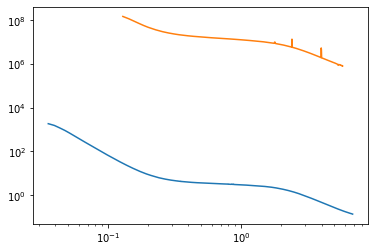

In [19]:
fig, ax = plt.subplots()
ax.plot(ref0_q, ref0_I)
ax.fill_between(ref_q, ref_I + scale * ref_e, ref_I - scale * ref_e, alpha=0.5)
ax.plot(ref_q, ref_I)
ax.loglog()

In [21]:
sp.integrate(ref0_I)

NameError: name 'sp' is not defined

[]

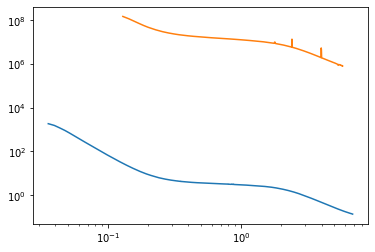

In [118]:
fig, ax = plt.subplots()
ax.plot(ref0_q, ref0_I)
ax.fill_between(q, I + scale * e, I - scale * e, alpha=0.5)
ax.plot(q, I)
ax.loglog()

In [101]:
metaFrame[x_Center][usedReference_index]

456.736

In [99]:
metaFrame[x_Center]

0     456.736
1     456.736
2     456.736
3     456.736
4     456.736
5     456.736
6     456.736
7     456.736
8     456.736
9     456.736
10    456.736
11    456.736
12    456.736
13    456.736
14    456.736
15    456.736
16    456.736
17    456.736
Name: x_Center, dtype: float64